In [1]:
import pandas as pd
import numpy as np
import lftk
import spacy

In [2]:
nlp = spacy.load("en_core_web_sm")

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv(r"Datasets\Fake News Dataset\fake_news_preprocess.csv")

In [4]:
data

,id,text,Polarity
0,8476,"You Can Smell Hillary’s FearDaniel Greenfield,...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,0
2,3608,Kerry to go to Paris in gesture of sympathyU.S...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,0
4,875,The Battle of New York: Why This Primary Matte...,1
...,...,...,...
6330,4490,State Department says it can't find emails fro...,1
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,0
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,0
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...",1


## LFTK Features

In [5]:
features_info_df = lftk.search_features(return_format="pandas")

In [6]:
len(features_info_df)

220

In [7]:
# features_info_df.loc[:50]

In [8]:
extra_features_exclude = ["average_subtlex_us_zipf_of_words_per_word", "average_subtlex_us_zipf_of_words_per_sentence"]

In [9]:
unique_pos_features = [feature["name"] for feature in lftk.search_features(family="partofspeech")]
avg_ents_features = [feature["name"] for feature in lftk.search_features(family="avgentity")]
ents_features = [feature["name"] for feature in lftk.search_features(family="entity")]


features_not_include = ents_features + avg_ents_features + unique_pos_features
print(len(features_not_include))

91


In [10]:
# features_not_include

In [11]:
features_dictionary = lftk.search_features(return_format="list_dict")

In [12]:
features_dictionary[0].keys()

dict_keys(['key', 'name', 'formulation', 'domain', 'family', 'language'])

In [13]:
features_to_extract = [feature["key"] for feature in features_dictionary if feature["name"] not in features_not_include]

In [14]:
len(features_to_extract)

128

In [15]:
features_info_df[features_info_df["key"].isin(features_to_extract)]

,key,name,formulation,domain,family,language
0,t_word,total_number_of_words,foundation,surface,wordsent,general
1,t_stopword,total_number_of_stop_words,foundation,surface,wordsent,general
3,t_syll,total_number_of_syllables,foundation,surface,wordsent,en
4,t_syll2,total_number_of_words_more_than_two_syllables,foundation,surface,wordsent,en
5,t_syll3,total_number_of_words_more_than_three_syllables,foundation,surface,wordsent,en
...,...,...,...,...,...,...
215,cole,coleman_liau_index,derivation,surface,readformula,en
216,auto,automated_readability_index,derivation,surface,readformula,en
217,rt_fast,reading_time_for_fast_readers,derivation,surface,readtimeformula,en
218,rt_average,reading_time_for_average_readers,derivation,surface,readtimeformula,en


# Extracting Features for a Random Sample

In [16]:
data.columns

Index(['id', 'text', 'Polarity'], dtype='object')

In [17]:
random_sample_data_true = data[data["Polarity"] == 1].sample(n=200, random_state=20)
random_sample_data_fake = data[data["Polarity"] == 0].sample(n=200, random_state=20)

In [18]:
random_sample = random_sample_data_true["text"].to_list() + random_sample_data_fake["text"].to_list() 
y_random_sample = random_sample_data_true["Polarity"].to_list() + random_sample_data_fake["Polarity"].to_list() 

In [19]:
docs_random_sample = [nlp(news) for news in random_sample]

In [20]:
LFTK = lftk.Extractor(docs = docs_random_sample)
LFTK.customize(stop_words = True, round_decimal = 2)

In [21]:
random_sample_feature_transform = LFTK.extract(features=features_to_extract)

In [22]:
random_sample_features_df = pd.DataFrame(random_sample_feature_transform)

In [23]:
random_sample_features_df.head()

,t_word,t_stopword,t_syll,t_syll2,t_syll3,t_uword,t_sent,t_char,a_word_ps,a_char_ps,...,a_space_ps,fkre,fkgl,fogi,smog,cole,auto,rt_fast,rt_average,rt_slow
0,22,9,25,1,1,22,2,92,11.00,46.00,...,0.00,99.53,2.11,6.22,4.04,6.10,3.77,0.07,0.09,0.13
1,331,119,476,49,19,172,13,1589,25.46,122.23,...,1.31,59.33,11.31,16.11,6.91,11.27,13.91,1.10,1.38,1.89
2,401,193,612,65,27,193,20,2012,20.05,100.60,...,0.40,57.37,10.24,14.50,6.64,12.23,12.23,1.34,1.67,2.29
3,769,336,1169,133,52,392,35,3683,21.97,105.23,...,0.74,55.93,10.92,15.71,6.96,11.01,12.11,2.56,3.20,4.39
4,1898,950,2650,263,88,654,83,8672,22.87,104.48,...,0.48,65.51,9.80,14.69,5.88,9.77,11.52,6.33,7.91,10.85


In [24]:
features_mapping = {feature["key"]:feature["name"] for feature in features_dictionary if feature["key"] in features_to_extract}

In [25]:
# features_mapping

In [26]:
random_sample_features_df.columns = features_mapping.values()

In [27]:
random_sample_features_df.to_csv(r"Datasets/Processed Data/random_sample_features_df.csv", index=False)

In [28]:
random_sample_features_df = pd.read_csv(r"Datasets/Processed Data/random_sample_features_df.csv")

In [29]:
random_sample_features_df.columns = features_mapping.keys()
y_df = pd.DataFrame(y_random_sample, columns=["polarity"])
random_sample_features_df = pd.concat([random_sample_features_df, y_df], axis=1)

random_sample_features_df.head()

,t_word,t_stopword,t_syll,t_syll2,t_syll3,t_uword,t_sent,t_char,a_word_ps,a_char_ps,...,fkre,fkgl,fogi,smog,cole,auto,rt_fast,rt_average,rt_slow,polarity
0,22,9,25,1,1,22,2,92,11.00,46.00,...,99.53,2.11,6.22,4.04,6.10,3.77,0.07,0.09,0.13,1
1,331,119,476,49,19,172,13,1589,25.46,122.23,...,59.33,11.31,16.11,6.91,11.27,13.91,1.10,1.38,1.89,1
2,401,193,612,65,27,193,20,2012,20.05,100.60,...,57.37,10.24,14.50,6.64,12.23,12.23,1.34,1.67,2.29,1
3,769,336,1169,133,52,392,35,3683,21.97,105.23,...,55.93,10.92,15.71,6.96,11.01,12.11,2.56,3.20,4.39,1
4,1898,950,2650,263,88,654,83,8672,22.87,104.48,...,65.51,9.80,14.69,5.88,9.77,11.52,6.33,7.91,10.85,1


### Correlation

In [30]:
corr_df = random_sample_features_df.corr()
corr_df

,t_word,t_stopword,t_syll,t_syll2,t_syll3,t_uword,t_sent,t_char,a_word_ps,a_char_ps,...,fkre,fkgl,fogi,smog,cole,auto,rt_fast,rt_average,rt_slow,polarity
t_word,1.000000,0.991017,0.997010,0.971803,0.924479,0.962652,0.972136,0.997944,0.025432,-0.011065,...,0.059305,-0.025391,-0.022225,0.038345,-0.082812,-0.029983,0.999999,1.000000,1.000000,0.113017
t_stopword,0.991017,1.000000,0.984020,0.950866,0.906714,0.948347,0.972202,0.984626,0.009460,-0.034070,...,0.087669,-0.050796,-0.047717,0.021695,-0.120221,-0.058315,0.991014,0.991011,0.991021,0.110509
t_syll,0.997010,0.984020,1.000000,0.985685,0.944122,0.965638,0.961583,0.999563,0.040626,0.012467,...,0.018297,0.007644,0.010154,0.072566,-0.040651,-0.000043,0.997013,0.997005,0.997003,0.103568
t_syll2,0.971803,0.950866,0.985685,1.000000,0.962489,0.952758,0.922042,0.982907,0.072196,0.059361,...,-0.059365,0.071532,0.086774,0.140345,0.038354,0.058492,0.971820,0.971790,0.971785,0.095877
t_syll3,0.924479,0.906714,0.944122,0.962489,1.000000,0.927774,0.869757,0.940027,0.073847,0.069605,...,-0.090729,0.092109,0.096173,0.241223,0.071605,0.075069,0.924485,0.924457,0.924452,0.115461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
auto,-0.029983,-0.058315,-0.000043,0.058492,0.075069,-0.016207,-0.170557,-0.004036,0.916105,0.978471,...,-0.862625,0.976391,0.942605,0.768755,0.757093,1.000000,-0.029952,-0.030031,-0.030036,0.065270
rt_fast,0.999999,0.991014,0.997013,0.971820,0.924485,0.962644,0.972154,0.997946,0.025416,-0.011054,...,0.059213,-0.025341,-0.022162,0.038421,-0.082712,-0.029952,1.000000,0.999999,0.999999,0.112974
rt_average,1.000000,0.991011,0.997005,0.971790,0.924457,0.962665,0.972149,0.997940,0.025386,-0.011113,...,0.059348,-0.025440,-0.022271,0.038324,-0.082851,-0.030031,0.999999,1.000000,0.999999,0.112956
rt_slow,1.000000,0.991021,0.997003,0.971785,0.924452,0.962651,0.972154,0.997940,0.025396,-0.011113,...,0.059354,-0.025440,-0.022289,0.038306,-0.082871,-0.030036,0.999999,0.999999,1.000000,0.112993


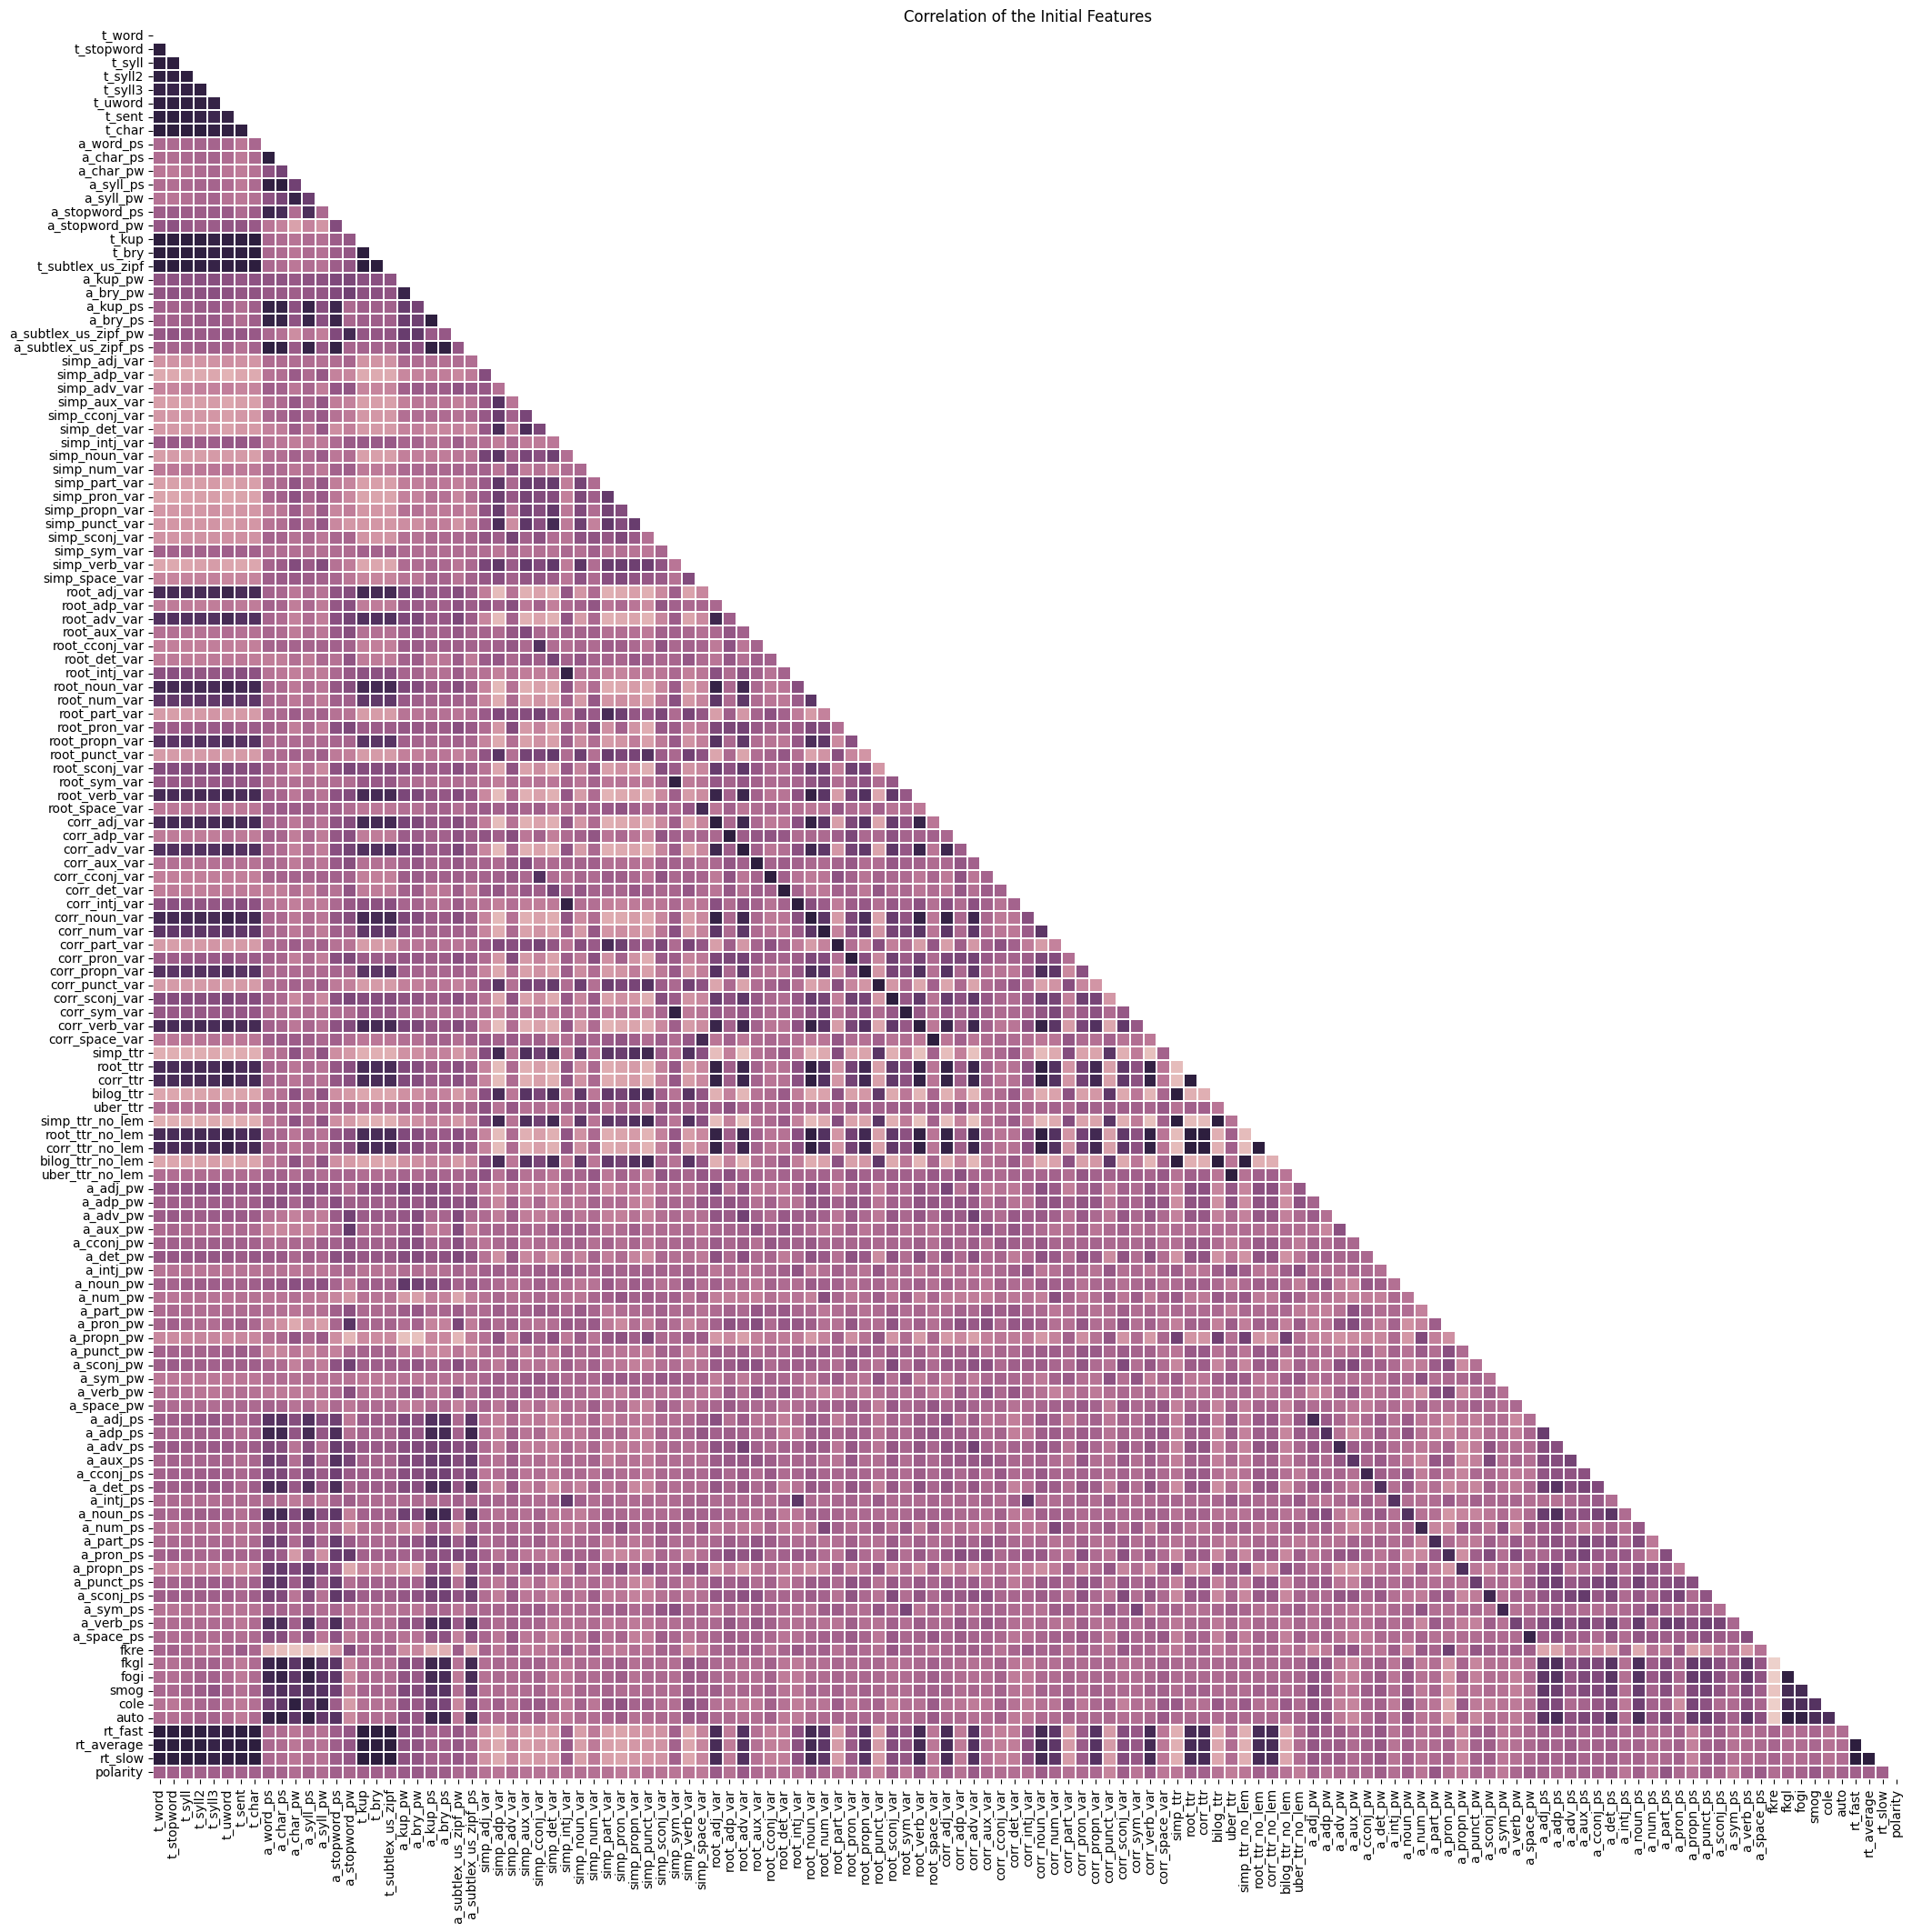

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

mask = np.triu(np.ones_like(corr_df, dtype=bool))

plt.figure(figsize=(25, 25))


cmap = sns.cubehelix_palette(as_cmap=True)
sns.heatmap(corr_df, mask = mask, linewidths=0.004, square=True, cmap = cmap, cbar = False)


plt.title("Correlation of the Initial Features")
plt.show()

### Checking Colinearity - Variance Inflation Factor

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(features, df):
    # print(features)
    X = df[features]
    X['intercept'] = 1
    
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    
    max_value = vif["VIF"].max()
    
    if max_value > 5:
        feature_max_value = list(vif[vif["VIF"] == max_value]["Variable"])[0]
        print("Eliminating ", feature_max_value)
        features.remove(feature_max_value)
        # print(features)
        print("Number of remaining features", len(features))
        vif = compute_vif(features, df)

    return vif

In [33]:
vif_df = compute_vif(list(random_sample_features_df.columns)[:-1], random_sample_features_df)

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Eliminating  simp_ttr
Number of remaining features 127


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Eliminating  root_ttr
Number of remaining features 126


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Eliminating  corr_ttr
Number of remaining features 125


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Eliminating  bilog_ttr
Number of remaining features 124


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Eliminating  uber_ttr
Number of remaining features 123


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  t_word
Number of remaining features 122


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  fkgl
Number of remaining features 121


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  rt_slow
Number of remaining features 120


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  rt_fast
Number of remaining features 119


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  corr_ttr_no_lem
Number of remaining features 118


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  corr_noun_var
Number of remaining features 117


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  corr_verb_var
Number of remaining features 116


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  root_adj_var
Number of remaining features 115


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  corr_propn_var
Number of remaining features 114


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  corr_intj_var
Number of remaining features 113


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  corr_adv_var
Number of remaining features 112


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  auto
Number of remaining features 111


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  corr_sym_var
Number of remaining features 110


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  corr_num_var
Number of remaining features 109


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  root_sconj_var
Number of remaining features 108


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  root_pron_var
Number of remaining features 107


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  root_adp_var
Number of remaining features 106


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_word_ps
Number of remaining features 105


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  t_syll
Number of remaining features 104


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  corr_aux_var
Number of remaining features 103


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  corr_space_var
Number of remaining features 102


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  root_punct_var
Number of remaining features 101


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  root_cconj_var
Number of remaining features 100


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  t_subtlex_us_zipf
Number of remaining features 99


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  fkre
Number of remaining features 98


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  corr_part_var
Number of remaining features 97


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  t_char
Number of remaining features 96


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  root_det_var
Number of remaining features 95


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_char_ps
Number of remaining features 94


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  t_kup
Number of remaining features 93


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_kup_ps
Number of remaining features 92


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_subtlex_us_zipf_ps
Number of remaining features 91


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  root_ttr_no_lem
Number of remaining features 90


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  rt_average
Number of remaining features 89


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_bry_ps
Number of remaining features 88


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  t_bry
Number of remaining features 87


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_syll_ps
Number of remaining features 86


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  cole
Number of remaining features 85


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_stopword_ps
Number of remaining features 84


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  simp_ttr_no_lem
Number of remaining features 83


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  t_uword
Number of remaining features 82


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  t_stopword
Number of remaining features 81


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_propn_pw
Number of remaining features 80


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  root_noun_var
Number of remaining features 79


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  t_syll2
Number of remaining features 78


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_noun_ps
Number of remaining features 77


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  root_verb_var
Number of remaining features 76


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_adp_ps
Number of remaining features 75


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_punct_ps
Number of remaining features 74


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  fogi
Number of remaining features 73


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_verb_ps
Number of remaining features 72


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_pron_pw
Number of remaining features 71


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  simp_det_var
Number of remaining features 70


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_det_ps
Number of remaining features 69


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  bilog_ttr_no_lem
Number of remaining features 68


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_adj_ps
Number of remaining features 67


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_stopword_pw
Number of remaining features 66


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  root_sym_var
Number of remaining features 65


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  simp_punct_var
Number of remaining features 64


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_num_pw
Number of remaining features 63


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  corr_adj_var
Number of remaining features 62


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_part_ps
Number of remaining features 61


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  root_intj_var
Number of remaining features 60


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_kup_pw
Number of remaining features 59


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_adv_ps
Number of remaining features 58


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_syll_pw
Number of remaining features 57


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_cconj_ps
Number of remaining features 56


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_space_ps
Number of remaining features 55


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  root_adv_var
Number of remaining features 54


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_sconj_ps
Number of remaining features 53


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  simp_adp_var
Number of remaining features 52


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  t_sent
Number of remaining features 51


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  simp_part_var
Number of remaining features 50


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  simp_aux_var
Number of remaining features 49


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_aux_ps
Number of remaining features 48


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_bry_pw
Number of remaining features 47


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  root_num_var
Number of remaining features 46


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_sym_ps
Number of remaining features 45


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  a_subtlex_us_zipf_pw
Number of remaining features 44


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Eliminating  simp_cconj_var
Number of remaining features 43


C:\Users\alber\AppData\Local\Temp\ipykernel_16320\1571046673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


In [34]:
vif_df

,Variable,VIF
0,t_syll3,4.786301
1,a_char_pw,3.858861
2,simp_adj_var,2.096231
3,simp_adv_var,1.917224
4,simp_intj_var,2.084603
5,simp_noun_var,2.872258
6,simp_num_var,1.387395
7,simp_pron_var,4.815147
8,simp_propn_var,3.653034
9,simp_sconj_var,3.564478


In [35]:
vif_features = vif_df["Variable"].to_list()

In [36]:
# vif_features

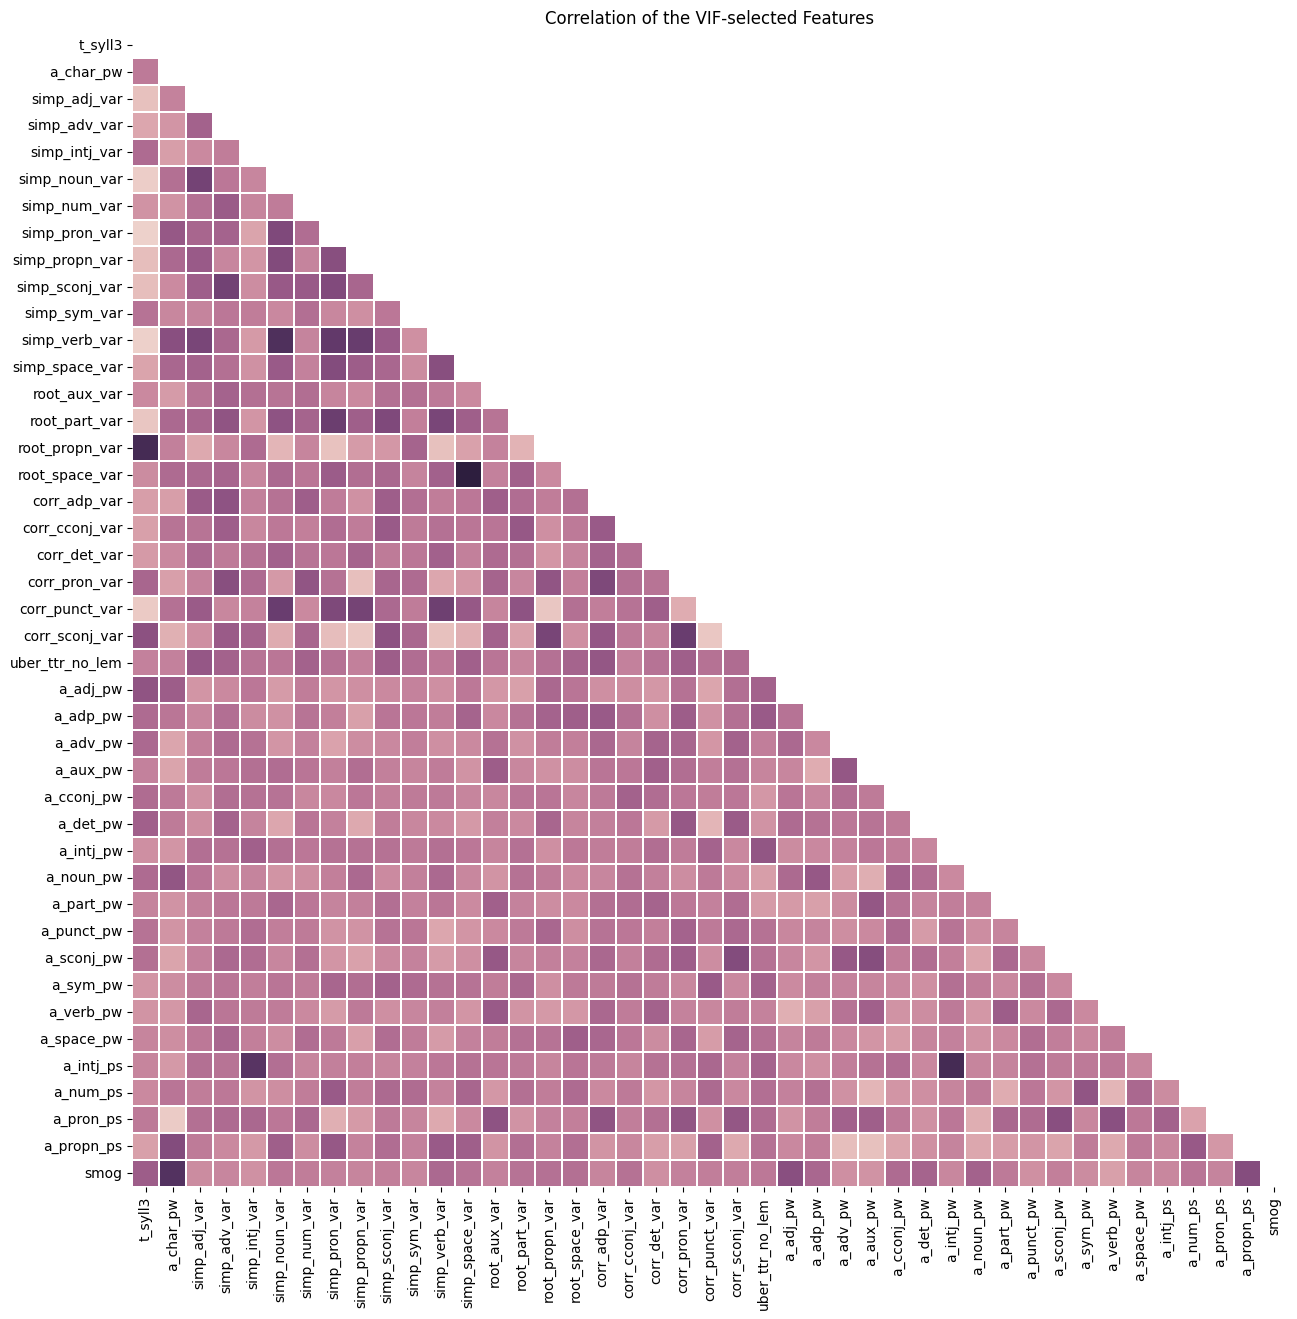

In [37]:
mask = np.triu(np.ones_like(random_sample_features_df[vif_features].corr(), dtype=bool))

plt.figure(figsize=(15, 15))


cmap = sns.cubehelix_palette(as_cmap=True)
sns.heatmap(random_sample_features_df[vif_features].corr(), mask = mask, linewidths=0.004, square=True, cmap = cmap, cbar = False)


plt.title("Correlation of the VIF-selected Features")
plt.show()

# Extracting the trimmed-down Features for the rest of the dataset

In [38]:
data_news = data["text"].to_list()
y_data = data["Polarity"].to_list()

docs = [nlp(news) for news in data_news]

LFTK = lftk.Extractor(docs = docs)
LFTK.customize(stop_words = True, round_decimal = 2)

data_features_extracted = LFTK.extract(features=vif_features)

In [39]:
features_info_df = pd.DataFrame(data_features_extracted)
data_features_extracted_df = pd.concat([pd.DataFrame(data_news, columns=["text"]), 
                                        pd.DataFrame(y_data, columns=["Polarity"]), 
                                        features_info_df], axis=1)

In [40]:
data_features_extracted_df.shape

(6335, 45)

In [41]:
data_features_extracted_df.columns

Index(['text', 'Polarity', 't_syll3', 'a_char_pw', 'simp_adj_var',
       'simp_adv_var', 'simp_intj_var', 'simp_noun_var', 'simp_num_var',
       'simp_pron_var', 'simp_propn_var', 'simp_sconj_var', 'simp_sym_var',
       'simp_verb_var', 'simp_space_var', 'root_aux_var', 'root_part_var',
       'root_propn_var', 'root_space_var', 'corr_adp_var', 'corr_cconj_var',
       'corr_det_var', 'corr_pron_var', 'corr_punct_var', 'corr_sconj_var',
       'uber_ttr_no_lem', 'a_adj_pw', 'a_adp_pw', 'a_adv_pw', 'a_aux_pw',
       'a_cconj_pw', 'a_det_pw', 'a_intj_pw', 'a_noun_pw', 'a_part_pw',
       'a_punct_pw', 'a_sconj_pw', 'a_sym_pw', 'a_verb_pw', 'a_space_pw',
       'a_intj_ps', 'a_num_ps', 'a_pron_ps', 'a_propn_ps', 'smog'],
      dtype='object')

In [42]:
data_features_extracted_df.head(10)

,text,Polarity,t_syll3,a_char_pw,simp_adj_var,simp_adv_var,simp_intj_var,simp_noun_var,simp_num_var,simp_pron_var,...,a_punct_pw,a_sconj_pw,a_sym_pw,a_verb_pw,a_space_pw,a_intj_ps,a_num_ps,a_pron_ps,a_propn_ps,smog
0,"You Can Smell Hillary’s FearDaniel Greenfield,...",0,56,4.22,0.80,0.66,0.0,0.66,0.60,0.17,...,0.08,0.02,0.0,0.11,0.02,0.00,0.06,1.39,1.77,4.58
1,Watch The Exact Moment Paul Ryan Committed Pol...,0,21,4.67,0.97,0.96,0.0,0.90,0.67,0.33,...,0.13,0.02,0.0,0.14,0.02,0.00,0.35,1.62,2.35,5.13
2,Kerry to go to Paris in gesture of sympathyU.S...,1,16,4.67,0.90,0.92,0.0,0.76,0.50,0.41,...,0.09,0.03,0.0,0.12,0.02,0.00,0.12,1.71,4.59,5.54
3,Bernie supporters on Twitter erupt in anger ag...,0,27,5.09,0.84,1.00,0.0,0.77,0.48,0.67,...,0.18,0.01,0.0,0.10,0.03,0.00,1.21,0.95,4.58,6.81
4,The Battle of New York: Why This Primary Matte...,1,11,4.31,0.85,0.92,0.0,0.65,1.00,0.43,...,0.15,0.02,0.0,0.12,0.03,0.00,0.38,1.00,2.76,4.13
5,"Tehran, USA \nI’m not an immigrant, but my gr...",0,121,4.44,0.62,0.54,0.0,0.63,0.90,0.09,...,0.15,0.02,0.0,0.13,0.01,0.00,0.19,2.91,1.61,6.16
6,Girl Horrified At What She Watches Boyfriend D...,0,12,4.44,0.95,0.86,1.0,0.74,1.00,0.28,...,0.12,0.04,0.0,0.16,0.01,0.10,0.20,4.00,1.90,4.43
7,‘Britain’s Schindler’ Dies at 106A Czech stock...,1,6,5.17,0.83,1.00,0.0,0.75,0.89,0.80,...,0.14,0.03,0.0,0.15,0.00,0.00,1.80,1.00,4.60,6.26
8,Fact check: Trump and Clinton at the 'commande...,1,80,4.52,0.57,0.59,1.0,0.43,0.71,0.16,...,0.15,0.04,0.0,0.13,0.03,0.01,0.42,1.39,4.02,5.08
9,Iran reportedly makes new push for uranium con...,1,27,4.82,0.67,0.84,0.0,0.60,0.87,0.33,...,0.09,0.03,0.0,0.13,0.02,0.00,0.47,0.84,2.88,5.25


In [43]:
data_features_extracted_df.to_csv(r"Datasets/Processed Data/data_features_extracted_df.csv", index=False)